# Chapter 2 에서 배울 내용

1. **분자 데이터 수집**  
   - 공개 데이터셋 다운로드 및 데이터 구조 확인
---
2. **분자 데이터 변환**  
   - SMILES 코드를 활용하여 Task에 적합한 형태로 데이터 변환
   - 변환된 데이터 형태와 타입 확인
---
3. **데이터 분할**
   - Random 분할 방식과 Scaffold 분할 방식 구현
   - 분할된 데이터 저장 및 불러오기
---


### Ignore warnings
코드 실행에서 불필요한 경고 문구 해제 

In [1]:
import warnings
from rdkit import RDLogger

warnings.simplefilter(action='ignore', category=FutureWarning)
RDLogger.DisableLog('rdApp.*')

### Library Import
코드 실행에 필요한 라이브러리를 호출

In [2]:
import os
import rdkit
import torch
import random
import numpy as np
import pandas as pd

from rdkit import Chem
from deepchem.feat.smiles_tokenizer import BasicSmilesTokenizer
from rdkit.Chem import Draw, AllChem, Descriptors, rdDepictor, rdDistGeom, MACCSkeys, rdMolDescriptors

from torch.utils.data import Dataset
from torch_geometric import utils as pyg_utils
from torch_geometric.data import InMemoryDataset, download_url, extract_gz, Data, DataLoader, Batch

# 작업을 위한 별도의 함수 불러오기
from utils.splitters_modified import random_split, scaffold_split ## split
from utils.download_preprocess import CustomMoleculeNet, atom_features, EDGE_FEATURES

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns

print(rdkit.__version__)

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
2024.03.6


## 1) 분자 데이터 수집

**MoleculeNet**은 화학 및 생물학적 데이터 분석과 모델링을 위한 벤치마크 데이터셋 모음이다.

주로 분자 특성 예측 및 약물 설계와 같은 분야에서 활용되며, 다양한 분자 특성과 데이터 분포를 포함하고 있다.

torch_geometric은 MoleculeNet 데이터를 간단하게 다운로드하고 처리할 수 있도록 지원한다.

이를 편리하게 이용할 수 있도록 본 예제 코드에서는 별도로 제작한 `CustomMoleculeNet` 함수를 이용한다.

MoleculeNet에서 제공하는 데이터셋은 목적에 따라 **Classification**과 **Regression**으로 분류할 수 있다.

아래 표는 MoleculeNet에서 제공하는 주요 데이터셋에 대해 정리한 표다.

출처: https://moleculenet.org/datasets-1

---

| 데이터셋 이름   | 문제 유형      | 설명                           |
|-----------------|---------------|--------------------------------|
| **HIV**         | Classification | 항바이러스 물질 활성 예측 (이진 분류) |
| **BACE**        | Classification | 알츠하이머 치료 물질 활성 예측 (이진 분류) |
| **BBBP**        | Classification | 혈액-뇌 장벽 투과성 예측 (이진 분류) |
| **Tox21**       | Classification | 화합물 독성 예측 (이진 분류)   |
| **ToxCast**     | Classification | 생물학적 독성 예측 (이진 분류) |
| **SIDER**       | Classification | 부작용 예측 (다중 클래스 분류) |
| **ClinTox**     | Classification | 독성 및 허가 여부 예측 (이진 분류) |
| **ESOL**        | Regression     | 분자의 용해도 예측            |
| **FreeSolv**    | Regression     | 분자의 수화 에너지 예측       |
| **Lipo**        | Regression     | 소수성(LogD) 예측             |

---

이번 실습에서는 **Classification 작업**을 위한 **BACE 데이터셋**과 **Regression 작업**을 위한 **ESOL 데이터셋**을 다운로드하여 활용한다.


### 데이터 다운로드

`CustomMoleculeNet`을 이용하여 원하는 데이터셋을 다운로드해 보자.

아래 실습 코드에서는 다운로드한 파일을 'dataset' 폴더에 저장하도록 설정하였다.

- **BACE**: 분류 작업을 위한 데이터셋으로, 라벨은 0 또는 1의 이진 값으로 구성된다.
- **ESOL**: 회귀 작업을 위한 데이터셋으로, 라벨은 연속형 값으로 구성된다.

In [3]:
# smiles와 label을 정보를 내려받음
bace = CustomMoleculeNet('dataset', name='BACE')
esol = CustomMoleculeNet('dataset', name='ESOL')

Data processed and saved successfully.
Data processed and saved successfully.


Processing...
Done!
Processing...
Done!


### 데이터 구조 확인

다운로드한 데이터셋의 구조를 확인해보자. 데이터 구조를 살펴보는 작업은 기초적이면서도 중요한 단계로, 이후 데이터 전처리와 모델 학습 결과 해석에 큰 영향을 미친다.

- **분자의 개수**: 데이터셋에 포함된 분자의 총 수를 확인한다.
- **포함된 정보**: 각 분자에 대한 정보(예: SMILES 문자열, 화학적 특성 등)가 어떻게 구성되어 있는지 파악한다.
- **라벨의 분포**: 라벨이 어떻게 분포되어 있는지 확인하여, 데이터가 균형 잡혀 있는지 혹은 불균형한지 점검한다. 이는 모델 설계 및 학습에 중요한 영향을 미칠 수 있다.

In [4]:
# 다운로드한 데이터셋 정보 불러오기
bace_data = torch.load('dataset/' + 'BACE' + '/processed/smiles_labels.pt')
esol_data = torch.load('dataset/' + 'ESOL' + '/processed/smiles_labels.pt')

In [5]:
# 분자의 개수, 포함된 정보 확인
print('BACE 데이터셋:')
print(f'분자 개수: {len(bace_data)}')
print(bace_data[:2])
print('---'*30)
print('ESOL 데이터셋:')
print(f'분자 개수: {len(esol_data)}')
print(esol_data[:2])

BACE 데이터셋:
분자 개수: 1513
[{'smiles': 'O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2ccccc2C)C)CC1(C)C', 'label': [[1.0]]}, {'smiles': 'Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(=O)C)(CC(C)C)C1=O)CCc1ccccc1)[C@H](O)[C@@H]1[NH2+]C[C@H](OCCC)C1', 'label': [[1.0]]}]
------------------------------------------------------------------------------------------
ESOL 데이터셋:
분자 개수: 1128
[{'smiles': 'OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', 'label': [[-0.7699999809265137]]}, {'smiles': 'Cc1occc1C(=O)Nc2ccccc2', 'label': [[-3.299999952316284]]}]


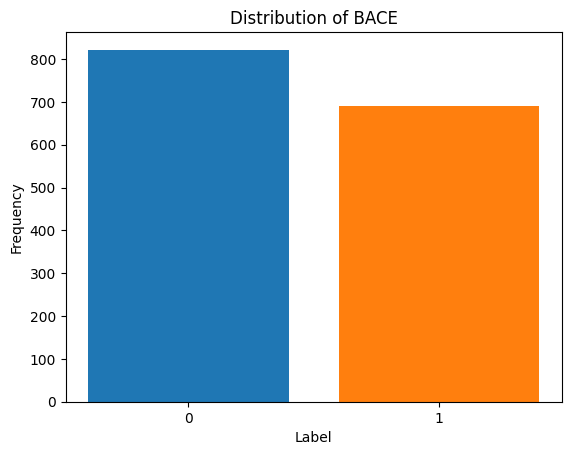

In [6]:
# 라벨의 분포
from collections import Counter

# BACE 라벨 리스트 (이진 벡터)
data = [smi['label'][0][0] for smi in bace_data]

# 데이터의 분포를 계산
counter = Counter(data)

# 막대 그래프 그리기
plt.bar(counter.keys(), counter.values(), color=['tab:orange', 'tab:blue'])

# x축 라벨을 0과 1로 설정
plt.xticks([0, 1])

# 그래프 제목과 레이블 추가
plt.title('Distribution of BACE')
plt.xlabel('Label')
plt.ylabel('Frequency')

# 그래프 표시
plt.show()

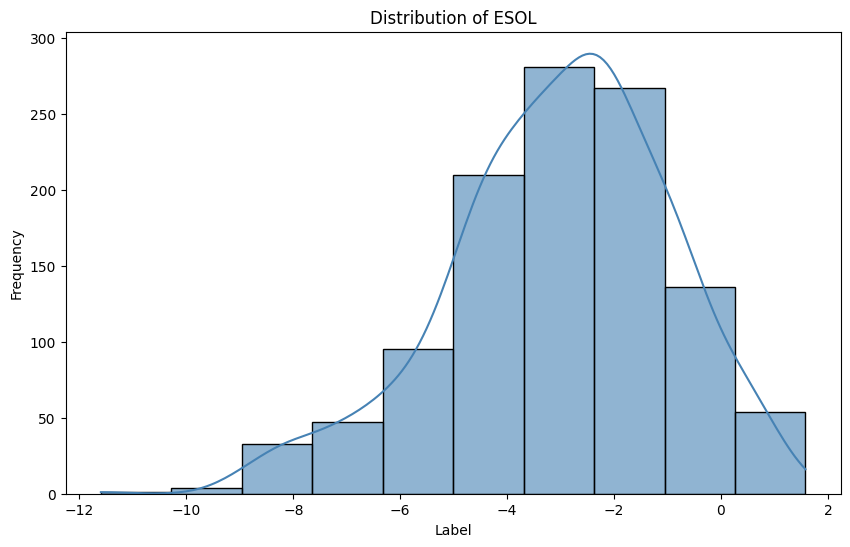

In [7]:
# ESOL 라벨 데이터 (연속형)
data = [smi['label'][0][0] for smi in esol_data]

# 히스토그램과 KDE(커널 밀도 추정)를 함께 그리기
plt.figure(figsize=(10, 6))
sns.histplot(data, kde=True, bins=10, color='steelblue', alpha=0.6)

# 그래프 제목과 레이블 추가
plt.title('Distribution of ESOL')
plt.xlabel('Label')
plt.ylabel('Frequency')

# 그래프 표시
plt.show()

## 2) 분자 데이터 변환

**Chapter 1**에서 배운 내용을 바탕으로, 분자 데이터를 목적에 맞게 변환해 보자.

아래 표는 목적에 맞는 다양한 분자 데이터 형태를 간단히 정리한 것이다.

---

| 데이터 형태  |  용도   | 설명                                                 |
|-----------------|-----------------|------------------------------------------------------|
| **SMILES**      | 문자열 처리     | 분자의 구조를 텍스트 형식으로 표현하며, 모델 입력을 위한 벡터화 과정이 필요함 |
| **Fingerprints** | 구조적 특징 벡터 | 분자의 구조적 특징 유무를 이진 벡터로 변환하여, 주로 분자 간의 유사도 계산에 사용됨 |
| **Descriptors** | 수치화된 화학적 특성 | 분자의 화학적 및 물리적 특성을 수치화한 값으로, 주로 분자 특성 예측에 사용됨 |
| **Image**      | 이미지 학습 | 분자의 2D/3D 구조를 이미지로 변환하여 합성곱 신경망(CNN)을 통한 학습을 수행 |
| **Graph**      | 그래프 학습      | 분자의 원자와 결합을 노드와 엣지로 표현하여, 그래프 신경망(GNN)을 통한 구조적 관계 학습에 활용 |

---

각 방법은 해당 작업의 목적에 맞는 데이터 표현 방식을 제공하며, 목표로 하는 예측 작업에 맞게 적절히 활용될 수 있다.

### SMILES 변환 함수 

**Chapter 1**에서 설계한 함수를 활용해보자.

#### 주요 수정 및 추가 사항:
- **출력 형식 변경**: 변환된 데이터는 `torch_geometric`의 `Data` 객체로 반환된다.  
- **라벨 처리 추가**: 입력으로 제공된 `label` 정보를 `Data` 객체의 `y` 값으로 함께 처리한다.  
- **SMILES 원본 표시**: 변환된 데이터가 어떤 SMILES에서 생성되었는지 추적 가능하도록 구현했다.

In [8]:
from torch_geometric.data import Data

def transform_mol(molecule_smiles, labels, choice):
    mols = [Chem.MolFromSmiles(mol) for mol in molecule_smiles if mol]
    
    # string tokenization
    if choice == 'string_tokenization': # vocab dictionary, encoded smiles를 출력
        vocab = []
        max_len = 0
        tokenizer = BasicSmilesTokenizer()
        for smi in molecule_smiles:
            tokens = tokenizer.tokenize(smi)
            max_len = max(max_len, len(tokens))
            vocab += tokens
            
        uniq_vocab = sorted(set(vocab))
        smiles_vocab = {v: i for i, v in enumerate(uniq_vocab)}
        smiles_vocab['Unk'] = len(smiles_vocab)
        
        encoded_smiles = [[smiles_vocab.get(token, smiles_vocab['Unk']) for token in tokenizer.tokenize(smi)] for smi in molecule_smiles]
        smiles_vec = []
        for vec, l, smi in zip(encoded_smiles, labels, molecule_smiles):
            pad_len = max_len - len(vec)
            vec = vec + ([0] * pad_len)
            smiles_vec.append(Data(x=torch.tensor(vec).view(1, -1), y=torch.tensor([l], dtype=torch.float).view(1, -1), smiles=smi))
        return smiles_vocab, smiles_vec

    # 2D Graph
    elif choice == '2D_graph':
        graph_data = [pyg_utils.from_smiles(smi) for smi in molecule_smiles]

        graph_2d = []
        for g, l, smi in zip(graph_data, labels, molecule_smiles):
            g.y = torch.tensor([l], dtype=torch.float).view(1, -1)
            g.smiles = smi
            graph_2d.append(g)
        return graph_2d

    # 3D Graph
    elif choice == '3D_graph':
        graph_3d = []
        for smi, l in zip(molecule_smiles, labels):
            graph_data = pyg_utils.from_smiles(smi)
            
            mol = Chem.MolFromSmiles(smi)
            atom_info = [(atom.GetIdx(), atom.GetSymbol()) for atom in mol.GetAtoms()]
                     
            mol = AllChem.AddHs(mol, addCoords=True)
            rdDistGeom.EmbedMolecule(mol)
    
            conf = mol.GetConformer()
            pos = np.array([conf.GetAtomPosition(idx) for idx, symbol in atom_info])
            graph_data.pos = pos
            graph_data.y = torch.tensor([l], dtype=torch.float).view(1, -1)
            graph_data.smiles = smi
            graph_3d.append(graph_data)
        return graph_3d
    
    # Fingerprint
    elif 'fingerprint' in choice:
        if choice == 'rdkit_fingerprint':
            fp = [Chem.RDKFingerprint(mol) for mol in mols]
        
        elif choice == 'maccs_fingerprint':
            fp = [MACCSkeys.GenMACCSKeys(mol) for mol in mols]
        
        elif choice == 'morgan_fingerprint':
            fp = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024) for mol in mols]

        fps = [Data(x=torch.tensor(f).view(1, -1), y=torch.tensor([l], dtype=torch.float).view(1, -1), smiles=smi) for f, l, smi in zip(fp, labels, molecule_smiles)]
        return fps

    # Descriptors
    elif choice == 'descriptors':
        # 모델 학습을 위해서는 스케일링 작업이 별도로 필요하다는 것을 기억하자!
        desc = []
        for mol, l, smi in zip(mols, labels, molecule_smiles):
            x = torch.tensor(list(Descriptors.CalcMolDescriptors(mol).values()), dtype=torch.float).view(1, -1)
            y = torch.tensor([l], dtype=torch.float).view(1, -1)
            desc.append(Data(x=x, y=y, smiles=smi))
        return desc

In [9]:
# smiles와 label 데이터 분리
bace_smis = [item['smiles'] for item in bace_data]
bace_labels = [item['label'] for item in bace_data]

esol_smis = [item['smiles'] for item in esol_data]
esol_labels = [item['label'] for item in esol_data]

### String tokenization

In [10]:
bace_vocab, bace_token = transform_mol(bace_smis, bace_labels, 'string_tokenization')
print('BACE 단어집 :', bace_vocab, '\n')
print('Token으로 변환된 BACE 데이터 :')
bace_token[:5]

BACE 단어집 : {'(': 0, ')': 1, '-': 2, '/': 3, '1': 4, '2': 5, '3': 6, '4': 7, '=': 8, 'Br': 9, 'C': 10, 'Cl': 11, 'F': 12, 'I': 13, 'N': 14, 'O': 15, 'S': 16, '[C@@H]': 17, '[C@@]': 18, '[C@H]': 19, '[C@]': 20, '[N+]': 21, '[N-]': 22, '[N@@H+]': 23, '[N@H+]': 24, '[NH+]': 25, '[NH2+]': 26, '[NH3+]': 27, '[O-]': 28, '[n+]': 29, '[n-]': 30, '[nH]': 31, '\\': 32, 'c': 33, 'n': 34, 'o': 35, 's': 36, 'Unk': 37} 

Token으로 변환된 BACE 데이터 :


[Data(x=[1, 178], y=[1, 1], smiles='O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2ccccc2C)C)CC1(C)C'),
 Data(x=[1, 178], y=[1, 1], smiles='Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(=O)C)(CC(C)C)C1=O)CCc1ccccc1)[C@H](O)[C@@H]1[NH2+]C[C@H](OCCC)C1'),
 Data(x=[1, 178], y=[1, 1], smiles='S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H]([C@H](O)C[NH2+]Cc1cc(OC)ccc1)Cc1ccccc1)C'),
 Data(x=[1, 178], y=[1, 1], smiles='S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c(N)c(F)c2)[C@H](O)[C@@H]([NH2+]Cc2cc(ccc2)C(C)(C)C)C1'),
 Data(x=[1, 178], y=[1, 1], smiles='S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H]([C@H](O)C[NH2+]Cc1cc(ccc1)C(F)(F)F)Cc1ccccc1)C')]

In [11]:
esol_vocab, esol_token = transform_mol(esol_smis, bace_labels, 'string_tokenization')
print('ESOL 단어집 :', esol_vocab, '\n')
print('Token으로 변환된 ESOL 데이터 :')
esol_token[:5]

ESOL 단어집 : {'(': 0, ')': 1, '/': 2, '1': 3, '2': 4, '3': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '=': 11, 'Br': 12, 'C': 13, 'Cl': 14, 'F': 15, 'I': 16, 'N': 17, 'O': 18, 'P': 19, 'S': 20, '[nH]': 21, '\\': 22, 'c': 23, 'n': 24, 'o': 25, 's': 26, 'Unk': 27} 

Token으로 변환된 ESOL 데이터 :


[Data(x=[1, 97], y=[1, 1], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O '),
 Data(x=[1, 97], y=[1, 1], smiles='Cc1occc1C(=O)Nc2ccccc2'),
 Data(x=[1, 97], y=[1, 1], smiles='CC(C)=CCCC(C)=CC(=O)'),
 Data(x=[1, 97], y=[1, 1], smiles='c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43'),
 Data(x=[1, 97], y=[1, 1], smiles='c1ccsc1')]

### Fingerprint

In [12]:
bace_fps = transform_mol(bace_smis, bace_labels, 'morgan_fingerprint')
print('Fingerprint로 변환된 BACE 데이터 :')
bace_fps[:5]

Fingerprint로 변환된 BACE 데이터 :


[Data(x=[1, 1024], y=[1, 1], smiles='O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2ccccc2C)C)CC1(C)C'),
 Data(x=[1, 1024], y=[1, 1], smiles='Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(=O)C)(CC(C)C)C1=O)CCc1ccccc1)[C@H](O)[C@@H]1[NH2+]C[C@H](OCCC)C1'),
 Data(x=[1, 1024], y=[1, 1], smiles='S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H]([C@H](O)C[NH2+]Cc1cc(OC)ccc1)Cc1ccccc1)C'),
 Data(x=[1, 1024], y=[1, 1], smiles='S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c(N)c(F)c2)[C@H](O)[C@@H]([NH2+]Cc2cc(ccc2)C(C)(C)C)C1'),
 Data(x=[1, 1024], y=[1, 1], smiles='S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H]([C@H](O)C[NH2+]Cc1cc(ccc1)C(F)(F)F)Cc1ccccc1)C')]

In [13]:
esol_fps = transform_mol(esol_smis, esol_labels, 'morgan_fingerprint')
print('Fingerprint로 변환된 ESOL 데이터 :')
esol_fps[:5]

Fingerprint로 변환된 ESOL 데이터 :


[Data(x=[1, 1024], y=[1, 1], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O '),
 Data(x=[1, 1024], y=[1, 1], smiles='Cc1occc1C(=O)Nc2ccccc2'),
 Data(x=[1, 1024], y=[1, 1], smiles='CC(C)=CCCC(C)=CC(=O)'),
 Data(x=[1, 1024], y=[1, 1], smiles='c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43'),
 Data(x=[1, 1024], y=[1, 1], smiles='c1ccsc1')]

### Descriptor

In [14]:
bace_desc = transform_mol(bace_smis, bace_labels, 'descriptors')
print('Descriptor로 변환된 BACE 데이터 :')
bace_desc[:5]

Descriptor로 변환된 BACE 데이터 :


[Data(x=[1, 210], y=[1, 1], smiles='O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2ccccc2C)C)CC1(C)C'),
 Data(x=[1, 210], y=[1, 1], smiles='Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(=O)C)(CC(C)C)C1=O)CCc1ccccc1)[C@H](O)[C@@H]1[NH2+]C[C@H](OCCC)C1'),
 Data(x=[1, 210], y=[1, 1], smiles='S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H]([C@H](O)C[NH2+]Cc1cc(OC)ccc1)Cc1ccccc1)C'),
 Data(x=[1, 210], y=[1, 1], smiles='S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c(N)c(F)c2)[C@H](O)[C@@H]([NH2+]Cc2cc(ccc2)C(C)(C)C)C1'),
 Data(x=[1, 210], y=[1, 1], smiles='S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H]([C@H](O)C[NH2+]Cc1cc(ccc1)C(F)(F)F)Cc1ccccc1)C')]

In [15]:
esol_desc = transform_mol(esol_smis, esol_labels, 'descriptors')
print('Descriptor로 변환된 ESOL 데이터 :')
esol_desc[:5]

Descriptor로 변환된 ESOL 데이터 :


[Data(x=[1, 210], y=[1, 1], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O '),
 Data(x=[1, 210], y=[1, 1], smiles='Cc1occc1C(=O)Nc2ccccc2'),
 Data(x=[1, 210], y=[1, 1], smiles='CC(C)=CCCC(C)=CC(=O)'),
 Data(x=[1, 210], y=[1, 1], smiles='c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43'),
 Data(x=[1, 210], y=[1, 1], smiles='c1ccsc1')]

### Graph

In [16]:
bace_graph = transform_mol(bace_smis, bace_labels, '2D_graph')
print('Graph로 변환된 BACE 데이터 :')
bace_graph[:5]

Graph로 변환된 BACE 데이터 :


[Data(x=[32, 9], edge_index=[2, 70], edge_attr=[70, 3], smiles='O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2ccccc2C)C)CC1(C)C', y=[1, 1]),
 Data(x=[47, 9], edge_index=[2, 100], edge_attr=[100, 3], smiles='Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(=O)C)(CC(C)C)C1=O)CCc1ccccc1)[C@H](O)[C@@H]1[NH2+]C[C@H](OCCC)C1', y=[1, 1]),
 Data(x=[42, 9], edge_index=[2, 92], edge_attr=[92, 3], smiles='S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H]([C@H](O)C[NH2+]Cc1cc(OC)ccc1)Cc1ccccc1)C', y=[1, 1]),
 Data(x=[40, 9], edge_index=[2, 84], edge_attr=[84, 3], smiles='S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c(N)c(F)c2)[C@H](O)[C@@H]([NH2+]Cc2cc(ccc2)C(C)(C)C)C1', y=[1, 1]),
 Data(x=[44, 9], edge_index=[2, 96], edge_attr=[96, 3], smiles='S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H]([C@H](O)C[NH2+]Cc1cc(ccc1)C(F)(F)F)Cc1ccccc1)C', y=[1, 1])]

In [17]:
esol_graph = transform_mol(esol_smis, esol_labels, '2D_graph')
print('Graph로 변환된 ESOL 데이터 :')
esol_graph[:5]

Graph로 변환된 ESOL 데이터 :


[Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1]),
 Data(x=[15, 9], edge_index=[2, 32], edge_attr=[32, 3], smiles='Cc1occc1C(=O)Nc2ccccc2', y=[1, 1]),
 Data(x=[11, 9], edge_index=[2, 20], edge_attr=[20, 3], smiles='CC(C)=CCCC(C)=CC(=O)', y=[1, 1]),
 Data(x=[22, 9], edge_index=[2, 52], edge_attr=[52, 3], smiles='c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43', y=[1, 1]),
 Data(x=[5, 9], edge_index=[2, 10], edge_attr=[10, 3], smiles='c1ccsc1', y=[1, 1])]

## 3) 데이터 분할 (Split)

**데이터 분할**은 전체 데이터셋을 학습(train), 검증(validation), 테스트(test) 데이터셋으로 나누는 과정으로,  
모델 학습과 평가를 독립적으로 수행하기 위해 반드시 필요한 단계다.

분자 데이터를 다룰 때는 주로 다음 두 가지 방식으로 분할을 수행한다:

---

#### 1. **Random Split**
- 데이터를 무작위로 섞어 학습, 검증, 테스트 데이터셋으로 나누는 방식.  
- **특징**:  
  - 데이터가 균일하게 분포되어 있다면 적합하다.  
  - 하지만, **특정 패턴**이나 **데이터 분포**가 있는 경우 성능 저하의 원인이 될 수 있다.

#### 2. **Scaffold Split**  
- 특정 분자의 중심이 되는 구조적 골격(Scaffold)를 기준으로 데이터를 분할하는 방식.
  - Scaffold는 다양한 작용기나 치환기가 결합된 상태에서 변경되지 않는 고정된 부분을 의미한다. 
  - 같은 Scaffold를 가진 분자는 동일한 데이터셋에 포함되도록 처리한다.  
- **특징**:  
  - 훈련과 테스트 간의 **구조적 중복**을 방지해, 모델이 새로운 Scaffold에 대해 일반화할 수 있는지 평가한다.  
  - 신약 개발과 같은 실제 환경에 가까운 평가를 제공한다.  
  - 단, 데이터 불균형이나 분할의 복잡성이 있을 수 있다.

---

MoleculeNet 지침에 따르면, 데이터셋은 **8:1:1** 비율로 학습(train), 검증(validation), 테스트(test) 데이터셋으로 분할하는 것을 권장한다.

특히, 데이터셋의 특성에 따라 분할 방식이 달라지며, BACE 데이터셋은 **Scaffold 분할**을, ESOL 데이터셋은 **Random 분할**을 사용하는 것이 지향된다.

In [18]:
# seed 설정 (데이터 로더를 재생성할 때 동일한 환경으로 실험 가능)
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [19]:
bace_mols = {'Token': bace_token, 'Fingerprint': bace_fps, 'Descriptors': bace_desc, 'Graph': bace_graph}
esol_mols = {'Token': esol_token, 'Fingerprint': esol_fps, 'Descriptors': esol_desc, 'Graph': esol_graph}

In [20]:
bace_split = {k: scaffold_split(v, bace_smis, null_value=0, frac_train=0.8, frac_valid=0.1, frac_test=0.1) for k, v in bace_mols.items()}
esol_split = {k: random_split(v, null_value=0, frac_train=0.8, frac_valid=0.1, frac_test=0.1, seed=seed) for k, v in esol_mols.items()}

### Split 시각화

Random Split 방식과 Scaffold Split 방식의 차이를 시각화를 통해 확인해보자.

In [21]:
# scaffold 추출 함수 생성 
from collections import Counter
from rdkit.Chem.Scaffolds import MurckoScaffold

def generate_scaffold_set(dataset, include_chirality=True):
    """
    Obtain Bemis-Murcko scaffold from smiles
    :param smiles:
    :param include_chirality:
    :return: smiles of scaffold
    """
    smiles = []
    scfs_list = []
    for data in dataset : 
        smiles.append(data.smiles)
        scaffold = MurckoScaffold.MurckoScaffoldSmiles(
            smiles=data.smiles, includeChirality=include_chirality)
        if len(scaffold) != 0:
            scfs_list.append(scaffold)
    scfs_list = [Chem.CanonSmiles(s) for s in scfs_list]
    scfs_freq = Counter(scfs_list)
    return scfs_freq, set(scfs_list)

def search_smarts(smiles, pattern):
    search = []
    s_pattern = Chem.MolFromSmarts(pattern)
    for smi in smiles:
        mol = Chem.MolFromSmiles(smi)
        if mol.HasSubstructMatch(s_pattern):
            search.append(smi)
    return search

#### Random 분할방식을 선택했을 때

In [22]:
esol_trn, esol_val, esol_tst = esol_split['Fingerprint']
len(esol_trn), len(esol_val), len(esol_tst)

(902, 112, 114)

In [23]:
# scaffold 추출 
trn_scfs, trn_smis = generate_scaffold_set(esol_trn)
val_scfs, val_smis = generate_scaffold_set(esol_val)
tst_scfs, tst_smis = generate_scaffold_set(esol_tst)

In [24]:
# 겹치는 scaffold 개수 확인
print(f"모든 ESOL dataset에서 겹치는 scaffold 개수 : {len(trn_scfs & val_scfs & tst_scfs)}")
print(f"train & valid에서 겹치는 scaffold 개수 : {len(trn_scfs & val_scfs)}")
print(f"valid & test에서 겹치는 scaffold 개수 : {len(tst_scfs & val_scfs)}")
print(f"train & test에서 겹치는 scaffold 개수 : {len(trn_scfs & tst_scfs)}")

모든 ESOL dataset에서 겹치는 scaffold 개수 : 11
train & valid에서 겹치는 scaffold 개수 : 33
valid & test에서 겹치는 scaffold 개수 : 11
train & test에서 겹치는 scaffold 개수 : 19


,Smiles,Frequency,ROMol
0,c1ccccc1,199,
1,c1ccc(-c2ccccc2)cc1,35,
2,c1ccc2ccccc2c1,20,
3,O=C1CC(=O)NC(=O)N1,19,
4,O=C1C=C2CCC3C4CCCC4CCC3C2CC1,13,

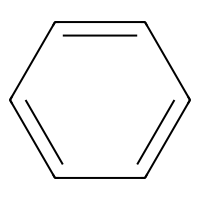
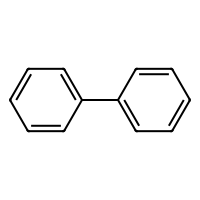
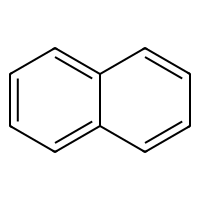
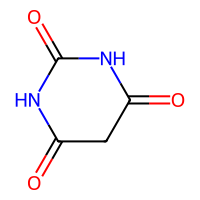
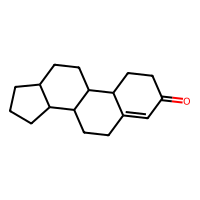

In [25]:
# 겹치는 scaffold가 어떤 구조이고 그 빈도를 확인
from rdkit.Chem import PandasTools
general_scfs = (trn_scfs & val_scfs & tst_scfs).keys()

all_scfs = trn_scfs | val_scfs | tst_scfs
all_scfs = {k:v for k, v in all_scfs.items() if k in general_scfs}

sorted_freq = sorted(all_scfs.items(), key=lambda item: item[1], reverse=True)
scf_df = pd.DataFrame(sorted_freq[:5], columns=['Smiles', 'Frequency'])

PandasTools.AddMoleculeColumnToFrame(scf_df)
PandasTools.RenderImagesInAllDataFrames(images=True)

scf_df

임의의 Scaffold를 하나 지정하여 데이터셋에 어떻게 분배되어 있는지 확인

Target Scaffold: O=C1CC(=O)NC(=O)N1


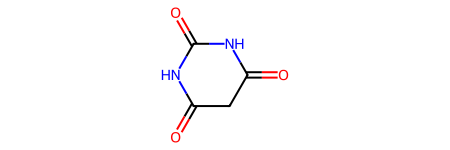

In [26]:
target_scf = scf_df['Smiles'][3]
print('Target Scaffold:', target_scf)
Chem.MolFromSmiles(target_scf)

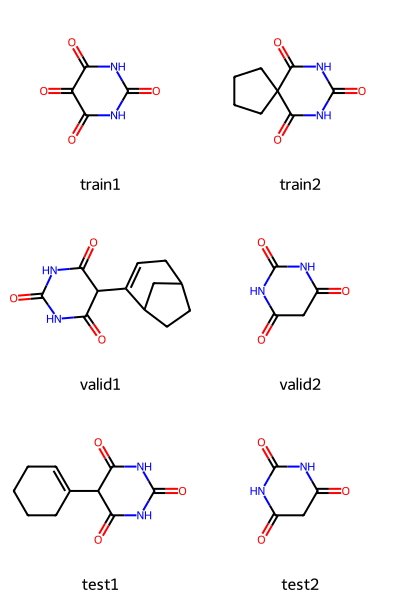

In [27]:
trn_finds = search_smarts(trn_smis, target_scf)
val_finds = search_smarts(val_smis, target_scf)
tst_finds = search_smarts(tst_smis, target_scf)

limit = min(len(trn_finds), len(val_finds), len(tst_finds))
limit = 5 if limit > 5 else limit
finds = trn_finds[:limit] + val_finds[:limit] + tst_finds[:limit]

mols = [Chem.MolFromSmiles(smi) for smi in finds]
legends = [item+str(i+1) for item in ['train', 'valid', 'test'] for i in range(limit)]
img_grid = Draw.MolsToGridImage(mols, molsPerRow=limit, subImgSize=(200, 200), legends=legends)
display(img_grid)

#### Scaffold 분할방식을 선택했을 때

In [28]:
bace_trn, bace_val, bace_tst = bace_split['Fingerprint']
len(bace_trn), len(bace_val), len(bace_tst)

(1210, 151, 152)

In [29]:
# scaffold 추출 
trn_scfs, trn_smis = generate_scaffold_set(bace_trn)
val_scfs, val_smis = generate_scaffold_set(bace_val)
tst_scfs, tst_smis = generate_scaffold_set(bace_tst)

In [30]:
# 겹치는 scaffold 개수 확인
print(f"모든 BACE dataset에서 겹치는 scaffold 개수 : {len(trn_scfs & val_scfs & tst_scfs)}")
print(f"train & valid에서 겹치는 scaffold 개수 : {len(trn_scfs & val_scfs)}")
print(f"valid & test에서 겹치는 scaffold 개수 : {len(tst_scfs & val_scfs)}")
print(f"train & test에서 겹치는 scaffold 개수 : {len(trn_scfs & tst_scfs)}")

모든 BACE dataset에서 겹치는 scaffold 개수 : 0
train & valid에서 겹치는 scaffold 개수 : 0
valid & test에서 겹치는 scaffold 개수 : 0
train & test에서 겹치는 scaffold 개수 : 0


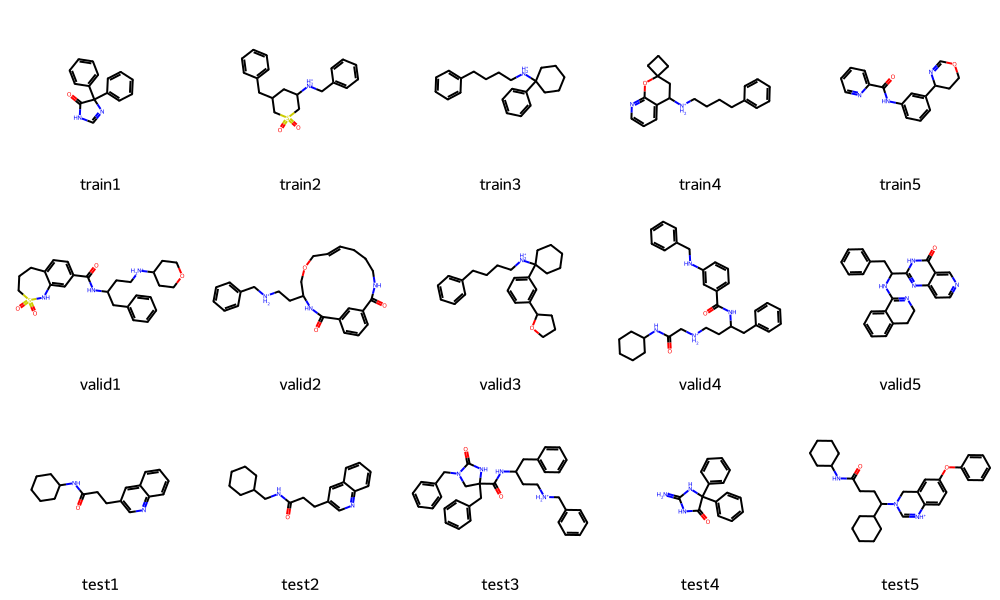

In [31]:
# 데이터셋 별로 가장 많이 가지고 있는 Scaffold를 상위 5개 선별하여 확인
sorted_trn = sorted(trn_scfs.items(), key=lambda item: item[1], reverse=True)[:5]
sorted_val = sorted(val_scfs.items(), key=lambda item: item[1], reverse=True)[:5]
sorted_tst = sorted(tst_scfs.items(), key=lambda item: item[1], reverse=True)[:5]
sorted_scfs = sorted_trn + sorted_val + sorted_tst

mols = [Chem.MolFromSmiles(smi[0]) for smi in sorted_scfs]
legends = [item+str(i+1) for item in ['train', 'valid', 'test'] for i in range(5)]
img_grid = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200), legends=legends)
display(img_grid)

#### 분할된 데이터 저장
- {데이터셋 명칭}_ {데이터 형식}_{훈련/검증/테스트}.pt 파일로 저장하기

In [32]:
# 저장할 위치 선택 
bace_save_path = 'dataset/' + 'bace' + '/processed/'
esol_save_path = 'dataset/' + 'esol' + '/processed/'

In [33]:
for tp in bace_split.keys():
    bace_trn, bace_val, bace_tst = bace_split[tp]
    torch.save(bace_trn, os.path.join(bace_save_path, f'bace_{tp}_train.pt'))
    torch.save(bace_val, os.path.join(bace_save_path, f'bace_{tp}_valid.pt'))
    torch.save(bace_tst, os.path.join(bace_save_path, f'bace_{tp}_test.pt'))
    print(f'BACE {tp} Saved..')

BACE Token Saved..
BACE Fingerprint Saved..
BACE Descriptors Saved..
BACE Graph Saved..


In [34]:
for tp in esol_split.keys():
    esol_trn, esol_val, esol_tst = esol_split[tp]
    torch.save(esol_trn, os.path.join(esol_save_path, f'esol_{tp}_train.pt'))
    torch.save(esol_val, os.path.join(esol_save_path, f'esol_{tp}_valid.pt'))
    torch.save(esol_tst, os.path.join(esol_save_path, f'esol_{tp}_test.pt'))
    print(f'ESOL {tp} Saved..')

ESOL Token Saved..
ESOL Fingerprint Saved..
ESOL Descriptors Saved..
ESOL Graph Saved..


In [35]:
# 저장된 파일 불러기기
bace_graph = torch.load(os.path.join(bace_save_path, 'bace_graph_test.pt'))
bace_graph[:5]

[Data(x=[23, 9], edge_index=[2, 50], edge_attr=[50, 3], smiles='O=C(N(C)C1CCCCC1)CCc1cc2c(nc1N)cccc2', y=[1, 1]),
 Data(x=[23, 9], edge_index=[2, 50], edge_attr=[50, 3], smiles='O=C(NCC1CCCCC1)CCc1cc2c(nc1N)cccc2', y=[1, 1]),
 Data(x=[45, 9], edge_index=[2, 98], edge_attr=[98, 3], smiles='O=C1NC(CN1Cc1ccccc1)(Cc1ccccc1)C(=O)NC(Cc1ccccc1)C(O)C[NH2+]Cc1cc(N(C)C)ccc1', y=[1, 1]),
 Data(x=[20, 9], edge_index=[2, 44], edge_attr=[44, 3], smiles='O=C1N(C)C(=[NH2+])NC1(c1ccccc1)c1ccccc1', y=[1, 1]),
 Data(x=[37, 9], edge_index=[2, 82], edge_attr=[82, 3], smiles='O(c1cc2CN(C(CCC(=O)N(C)C3CCCCC3)C3CCCCC3)C(=[NH+]c2cc1)N)c1ccccc1', y=[1, 1])]